# Estimating Power for two independent samples t-test

In this notebook, I show how to estimate power using a standard power solver and bootstrapping.    

## Contents
* [Power solver](#power_solver)     
* [Bootstrapping](#Bootstrapping)   


Remember a few concepts:    
The power of any test of statistical significance is defined as the probability that it will reject a false null hypothesis (a true positive).    
Statistical power is inversely related to beta or the probability of making a Type II error. 

Power = $1 − \beta = 1 − P$(type II error) = P( reject |$H_0$ false) $=$ P( $\overline{x}$ $\epsilon$ $R$ | $\mu \neq \mu_0$)

This is not aiming to review the theory of statistical power. 
The theory can be found elsewhere:      
https://newonlinecourses.science.psu.edu/stat500/node/46/    
http://statweb.stanford.edu/~susan/courses/s141/hopower.pdf    




In [1]:
import numpy as np
import pandas as pd
from statsmodels.stats.power import tt_solve_power, tt_ind_solve_power

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.figsize": (6, 4)})
sns.set_context('talk')

<a id='power_solver'> </a> 

# Power solver

Here we use a statsmodels power solver to compute power.   
We calculate power for different sample sizes.  

In [2]:
sample_sizes = np.arange(10, 110, 10)
effect_size = 0.5
alpha = 0.05
alternative = 'two-sided'

powers_solver = []
for sample_size in sample_sizes:
    power = tt_ind_solve_power(effect_size, nobs1=sample_size, ratio=1, alpha=alpha, alternative=alternative)
    powers_solver.append({'sample_size' : sample_size, 'power' : power})

powers_solver = pd.DataFrame(powers_solver)
powers_solver

,power,sample_size
0,0.185096,10
1,0.337939,20
2,0.477897,30
3,0.598147,40
4,0.696893,50
5,0.775266,60
6,0.835822,70
7,0.881602,80
8,0.915587,90
9,0.940427,100


<a id='bootstrapping'></a>  
# Bootstrapping     
Here I use bootstrapping to calculate power.   

In [3]:
from statsmodels.stats.weightstats import ttest_ind
repeats = 1000
mu1 = 0
mu2 = mu1 + effect_size
std = 1

# We could use directly np.random.normal inside the bootstrapping loop to randomly sample 
# a normal distribution. But in general, we usually have two groups of data and we draw samples from these groups as shown below.
group1 = np.random.normal(loc=mu1, scale=std, size=10000)
group2 = np.random.normal(loc=mu2, scale=std, size=10000)

def get_power(repeats, group1, group2, sample_size, alpha):
    """Gets power using bootstrapping     
    """
    rejects = 0
    for r in range(repeats):
        
        # bootstrapping draws with replacement
        x1 = np.random.choice(group1, sample_size, replace=True) 
        x2 = np.random.choice(group2, sample_size, replace=True) 
        
        # Two individual samples t-test
        tstat, pvalue, df = ttest_ind(x1, x2, alternative=alternative, value=0)
        # Since power is the probability of rejecting a Null when its false.
        # We count the times the null is rejected.
        if pvalue < alpha:
            rejects += 1
        
    power = np.round(float(rejects) / float(repeats), 2)
    return power

powers_boot = []
for sample_size in sample_sizes:
    power = get_power(repeats, group1, group2, sample_size, alpha)
    powers_boot.append({'sample_size' : sample_size, 'power' : power})

powers_boot = pd.DataFrame(powers_boot)
powers_boot

,power,sample_size
0,0.21,10
1,0.34,20
2,0.49,30
3,0.62,40
4,0.68,50
5,0.76,60
6,0.84,70
7,0.86,80
8,0.90,90
9,0.95,100


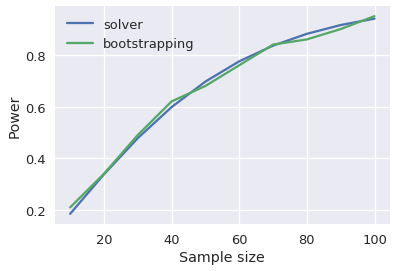

In [4]:
fig, ax = plt.subplots()

ax.plot(powers_solver['sample_size'], powers_solver['power'], label='solver')
ax.plot(powers_boot['sample_size'], powers_boot['power'], label='bootstrapping')

ax.set_xlabel('Sample size')
ax.set_ylabel('Power')

ax.legend(loc=0)
sns.despine()

As expected bootstrapping get's similar results as a standard solver.    